In [11]:
from typing import TypedDict,Literal
from langgraph.graph import StateGraph,START,END

In [8]:
class AgentClass(TypedDict):
    num1: int
    num2: int
    op1: Literal['*','+']
    num3: int
    num4: int
    op2: Literal['*','+']
    res1: int
    res2: int


In [13]:
def add(state: AgentClass) -> AgentClass:
    state['res1']=f"add: {state['num1']} + {state['num2']} = {state['num1']+state['num2']}"
    return state

def sub(state: AgentClass) -> AgentClass:
    state['res1'] = f"sub: {state['num1']} - {state['num2']} = {state['num1']- state['num2']}"

def router(state: AgentClass) -> str:
    if state['op1'] == '+':
        return 'add_op'
    else: 
        return 'sub_op'
    
def add2(state: AgentClass) -> AgentClass:
    state['res2']=f"add2: {state['num3']} + {state['num4']} = {state['num3']+state['num4']}"
    return state

def sub2(state: AgentClass) -> AgentClass:
    state['res2'] = f"sub2: {state['num3']} - {state['num4']} = {state['num3']- state['num4']}"
    return state

def router2(state: AgentClass) -> str:
    if state['op2'] == '+':
        return 'add_op2'
    else: 
        return 'sub_op2'
    

In [10]:
graph = StateGraph(AgentClass)

In [14]:
graph.add_node('addition_node',add)
graph.add_node('addition_node2',add2)
graph.add_node('substract_node',sub)
graph.add_node('substract_node2',sub2)
graph.add_node('router',lambda state:state)
graph.add_node('router2',lambda state:state)
graph.add_edge(START,'router')

graph.add_conditional_edges(
    'router',
    router,
    {
        "add_op":"addition_node",
        "sub_op":"substract_node"
    }
)
graph.add_edge('addition_node','router2')
graph.add_edge('substract_node','router2')

graph.add_conditional_edges(
    'router2',
    router2,
    {
        "add_op2":"addition_node2",
        "sub_op2":"substract_node2"
    }
)
graph.add_edge("addition_node2",END)
graph.add_edge("substract_node2",END)

app = graph.compile()


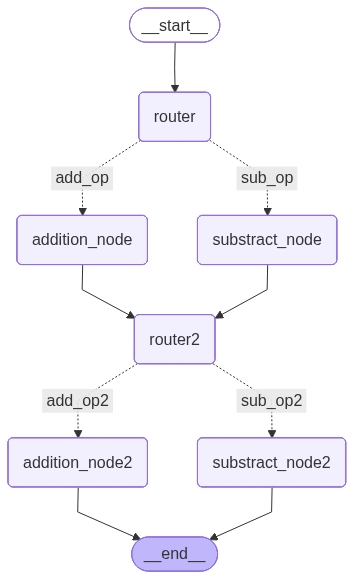

In [15]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [20]:
init = AgentClass(num1=10,num2=20,op1='+',num3=30,num4=10,op2='-')
result = app.invoke(init)

In [21]:
print(result)

{'num1': 10, 'num2': 20, 'op1': '+', 'num3': 30, 'num4': 10, 'op2': '-', 'res1': 'add: 10 + 20 = 30', 'res2': 'sub2: 30 - 10 = 20'}
